<center> 
<h3><b> Adnan Rashid </b><\h3>
<br><br>
    <nav>
    | <a href="00-Contents-Setup.ipynb"> Home Page </a> | 
    <a href="http://bit.ly/cka_notes_original"> Kubernetes Notes </a> |
    <a href="https://adnan.study"> Website </a> |
    <a href="https://www.instagram.com/adnans_techie_studies/"> Instagram </a> |
    <a href="https://www.linkedin.com/in/adnanrashid1/"> LinkedIn </a> |
    </nav>
</center>

<h1 style="background:black"><code style="background:black;color:white"><center>Autoscaling Apps and Clusters with HPA and CA</center></code></h1>

<div class="alert alert-block alert-warning">
<font style="color:black">
<center> We will go through patterns for scaling your worker nodes and application deployments automatically
</div>
</font>
</center>

<center><img src="https://adnanstudyimages.s3-eu-west-1.amazonaws.com/14.jpg" width="40%" height="40%" border=5/>

* [Configure Horizontal Pod AutoScaler (HPA)](#configurehpa)
* [Scale an Application with HPA](#scalehpa)
* [Configure Cluster Autoscaler](#configureca)
* [Scale a Cluster with CA](#scalecluster)
* [Cleanup](#cleanupclusterca)

<blockquote>

* <b> Horizontal Pod Autoscaler (HPA) </b> scales the pods in a deployment or replica set. It is implemented as a K8s API resource and a controller. The controller manager queries the resource utilization against the metrics specified in each HorizontalPodAutoscaler definition. It obtains the metrics from either the resource metrics API (for per-pod resource metrics), or the custom metrics API (for all other metrics).

* <b> Cluster Autoscaler (CA) </b>  a component that automatically adjusts the size of a Kubernetes Cluster so that all pods have a place to run and there are no unneeded nodes.

* Video explaining horizontal pod autoscaling

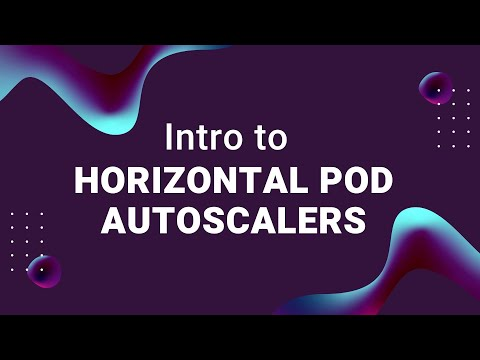

In [58]:
from IPython.display import YouTubeVideo
YouTubeVideo('Dor5xNHS_IY')

## Pre-requisite

* Check your variables are loaded

In [ ]:
%store

* Load in variable store

In [ ]:
%store -r 

* Load variables into notebook

In [ ]:
%env AWS_PROFILE=$AWS_PROFILE
%env AWS_DEFAULT_REGION=$AWS_DEFAULT_REGION
%env ACCOUNT_ID=$ACCOUNT_ID

* Check identity 

In [ ]:
!aws sts get-caller-identity

<br>

---
---

<br>

## Configure Horizontal Pod Autoscaler (HPA) <a class="anchor" id="configurehpa"></a>

#### Deploy the Metrics Server 

Metrics Server is a scalable, efficient source of container resource metrics for Kubernetes built-in autoscaling pipelines. 

These metrics will drive the scaling behavior of the deployments 

* Create the metrics-service namespace first

In [ ]:
!kubectl create namespace metrics

* Deploy the metrics server using Helm 

In [ ]:
%%bash

helm install metrics-server \
    stable/metrics-server \
    --version 2.9.0 \
    --namespace metrics

* Verify the status of the metrics-server APIService 

In [ ]:
!kubectl get apiservice v1beta1.metrics.k8s.io -o yaml 

<br><br>We are now ready to scale a deployed application 

## <br><br>Scale an Application with HPA <a class="anchor" id="scalehpa"></a>

#### Deploy a Sample App

The app is a custom built image based on the php-apache image. 

The index.php page performs calculations to generate CPU load. 

* Deploy a sample app and expose as a service on TCP port 80

In [ ]:
!kubectl create deployment php-apache --image=us.gcr.io/k8s-artifacts-prod/hpa-example
!kubectl set resources deploy php-apache --requests=cpu=200m
!kubectl expose deploy php-apache --port 80

* View the pods for the php-apache application

In [ ]:
!kubectl get pod -l app=php-apache

### <br><br>Create an HPA Resource

* This HPA Scales up when CPU exceeds 50% of the allocated container resource

In [ ]:
!kubectl autoscale deployment php-apache --cpu-percent=50 --min=1 --max=10

<bR>In the above the target average CPU utilisation is 50 

The lower limit for the number of pods that can be set by the autoscaler is 1 and the upper limit is 10 

* View the HPA using kubectl. You probably will see <b> unknown/50% </b> for 1-2 mins. Then you should be able to see <b>0%/50% </b>

In [ ]:
!kubectl get hpa

## <br><br>Generate load to trigger scaling

* Run the following in a terminal as it is interactive

<p style="background:black">
<code style="background:black;color:white">> kubectl run -i --tty load-generator --image=busybox /bin/sh
</code>
</p>

* If you need to connect for a second time for any reason 

<p style="background:black">
<code style="background:black;color:white">> kubectl exec --stdin --tty load-generator -- /bin/bash
</code>
</p>

* Run script to generate load in the terminal and return back here to continue to check the pods 

<p style="background:black">
<code style="background:black;color:white">> while true; do wget -q -O - http://php-apache; done
</code>
</p>

Check number of pods (you may need to execute the following cell a few times) 

* You will see HPA scale the pods from 1 to our configured maximum (10) until the CPU average is below our target (50%)

In [ ]:
!kubectl get hpa

You can now stop the terminal (Ctrl + C) 

You will notice that HPA will slowly bring the replica count to min number based on its configuration 

You should also get out of the load testing application by pressing Ctrl + D 

In [ ]:
!kubectl get hpa

# <br><br>Configure Cluster AutoScaler (CA) <a class="anchor" id="configureca"></a>

<blockquote> Cluster Autoscaler for AWS provides integration with Auto Scaling groups. It enables users to choose from four different options of deployment:

* One Auto Scaling group - This is what we will use
* Multiple Auto Scaling groups
* Auto-Discovery
* Master Node setup

    
Auto-Discovery is preferred method to configure Cluster Autoscaler. 
    
Cluster Autoscaler will attempt to determine the CPU, memory and GPU resources provided by an Auto Scaling Group based on the instance type specified in its Launch Configuration or Launch Template. 

## <br><br>Configure the ASG

You configure the size of your Auto Scaling group by setting the minimum, maximum and desired capacity.

* When we created the cluster we set these settings to 3 

In [ ]:
%%bash

aws autoscaling \
    describe-auto-scaling-groups \
    --query "AutoScalingGroups[? Tags[? (Key=='eks:cluster-name') && Value=='eksworkshop-eksctl']].[AutoScalingGroupName, MinSize, MaxSize,DesiredCapacity]" \
    --output table

* Get the ASG name

In [ ]:
!aws autoscaling describe-auto-scaling-groups --query "AutoScalingGroups[? Tags[? (Key=='eks:cluster-name') && Value=='eksworkshop-eksctl']].AutoScalingGroupName" --output text

* Set the environment variable

In [ ]:
%env ASG_NAME=<INSERT ABOVE VALUE>

* Increase max capacity to 4 

In [ ]:
%%bash
aws autoscaling \
    update-auto-scaling-group \
    --auto-scaling-group-name ${ASG_NAME} \
    --min-size 3 \
    --desired-capacity 3 \
    --max-size 4

* Check the new values 

In [ ]:
%%bash
aws autoscaling \
    describe-auto-scaling-groups \
    --query "AutoScalingGroups[? Tags[? (Key=='eks:cluster-name') && Value=='eksworkshop-eksctl']].[AutoScalingGroupName, MinSize, MaxSize,DesiredCapacity]" \
    --output table

## <br><br>IAM roles for service accounts 

<blockquote>IAM roles for service accounts on Amazon EKS clusters, you can associate an IAM role with a Kubernetes Service Account <br><br>
This service account can then provide AWS permissions to the containers in any pod that uses that service account <br><br>
<b>With this feature, you no longer need to provide extended permissions to the node IAM role so that pods on that node can call AWS APIs </b>

* Enabling IAM roles for service accounts on your cluster 

In [ ]:
!eksctl utils associate-iam-oidc-provider --cluster eksworkshop-eksctl --approve

* Creating an IAM policy for your service account that will allow your CA pod to interact with the autoscaling groups

In [ ]:
!aws iam create-policy --policy-name k8s-asg-policy --policy-document file://cluster-autoscaler/k8s-asg-policy.json

* Create an IAM role for the cluster-autoscaler Service Account in the kube-system namespace

In [ ]:
%%bash
eksctl create iamserviceaccount \
    --name cluster-autoscaler \
    --namespace kube-system \
    --cluster eksworkshop-eksctl \
    --attach-policy-arn "arn:aws:iam::${ACCOUNT_ID}:policy/k8s-asg-policy" \
    --approve \
    --override-existing-serviceaccounts

* Make sure your service account with the ARN of the IAM role is annotated

In [ ]:
!kubectl -n kube-system describe sa cluster-autoscaler

## <br><br> Deploy the Cluster Autoscaler (CA)

* Deploy the Cluster AutoScaler to your cluster

In [ ]:
!kubectl apply -f cluster-autoscaler/cluster-autoscaler-autodiscover.yaml

* To prevent CA from removing nodes where its own pod is running, we will add the <b>'cluster-autoscaler.kubernetes.io/safe-to-evict'</b> annotation to its deployment

In [ ]:
%%bash

kubectl -n kube-system \
annotate deployment.apps/cluster-autoscaler \
cluster-autoscaler.kubernetes.io/safe-to-evict="false"

* Get the latest docker image available for our EKS version 

In [ ]:
!kubectl version --short | grep 'Server Version:' | sed 's/[^0-9.]*\([0-9.]*\).*/\1/' | cut -d. -f1,2

* Set Env Var

In [ ]:
%env K8S_VERSION=1.17

* AutoScaler Version 

In [ ]:
!curl -s "https://api.github.com/repos/kubernetes/autoscaler/releases" | grep '"tag_name":' | sed 's/.*-\([0-9][0-9\.]*\).*/\1/' | grep -m1 ${K8S_VERSION}

* Set Env Var

In [ ]:
%env AUTOSCALER_VERSION=1.17.3

* Update the autoscaler image

In [ ]:
%%bash

kubectl -n kube-system \
    set image deployment.apps/cluster-autoscaler \
    cluster-autoscaler=us.gcr.io/k8s-artifacts-prod/autoscaling/cluster-autoscaler:v${AUTOSCALER_VERSION}

* Watch the logs 

In [ ]:
!kubectl -n kube-system logs -f deployment/cluster-autoscaler

<br><br>We are now ready to scale our cluster

# <br><br> Scale a Cluster with CA <a class="anchor" id="scalecluster"></a>

#### Deploy a Sample App

* We will deploy an sample nginx application as a ReplicaSet of 1 Pod 

In [ ]:
!kubectl apply -f cluster-autoscaler/nginx.yaml

In [ ]:
!kubectl get deployment/nginx-to-scaleout

#### <br><br>Scale out ReplicaSet 

* Lets scale out the replicaset to 10 

In [ ]:
!kubectl scale --replicas=10 deployment/nginx-to-scaleout

* Some pods will be in the <b>'Pending'</b> state, which triggers the cluster-autoscaler to scale out the EC2 fleet.

In [ ]:
!kubectl get pods -l app=nginx -o wide

* View the cluster-autoscaler logs

Warning: This is really long, may be better to run in terminal

In [ ]:
!kubectl -n kube-system logs -f deployment/cluster-autoscaler

* Check AutoScaling groups are scaling by either looking at the AWS console or checking nodes

In [ ]:
!kubectl get nodes

## <br><br>Clean up <a class="anchor" id="cleanupclusterca"></a>

In [ ]:
!kubectl delete -f cluster-autoscaler/nginx.yaml

In [ ]:
!kubectl delete -f cluster-autoscaler/cluster-autoscaler-autodiscover.yaml

In [ ]:
%%bash 

eksctl delete iamserviceaccount \
  --name cluster-autoscaler \
  --namespace kube-system \
  --cluster eksworkshop-eksctl \
  --wait

aws autoscaling \
  update-auto-scaling-group \
  --auto-scaling-group-name ${ASG_NAME} \
  --min-size 3 \
  --desired-capacity 3 \
  --max-size 3


In [ ]:
!kubectl delete hpa,svc php-apache
!kubectl delete deployment php-apache
!kubectl delete pod load-generator
!kubectl delete ns metrics

In [ ]:
!helm -n metrics uninstall metrics-server